# Returning the echo distance

This notebook uses the water tank model from the previous notebook, with a solution to generating source positions and measurement setups and returning a point from the echo.

In [1]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt 
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

In [2]:
def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res

In [3]:
class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


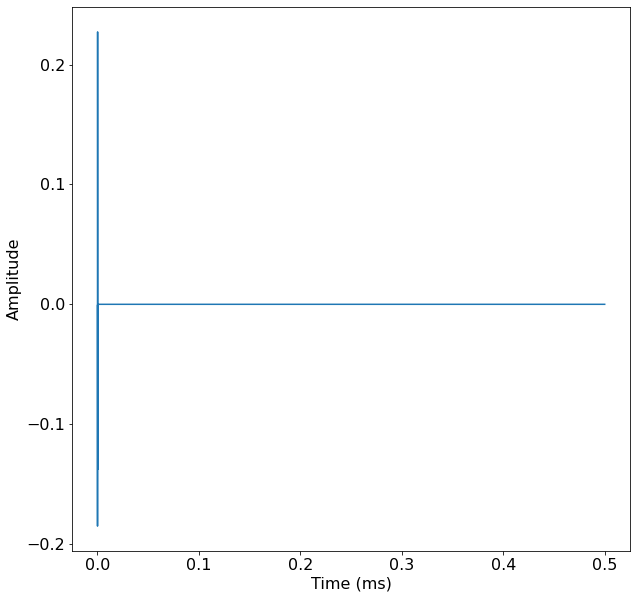

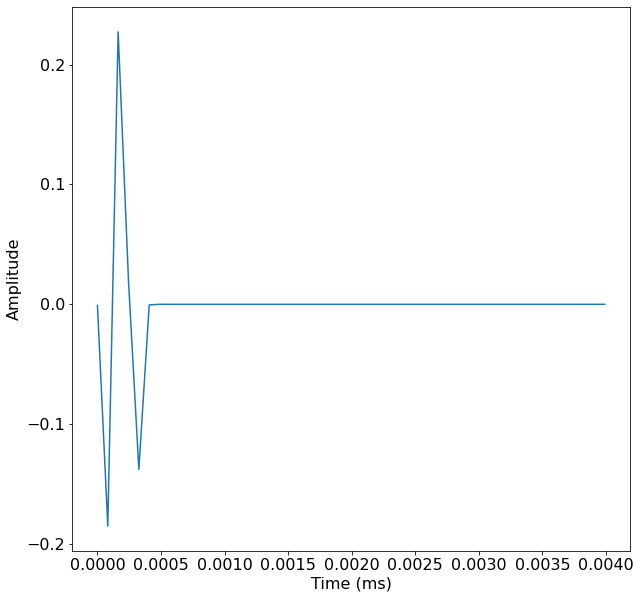

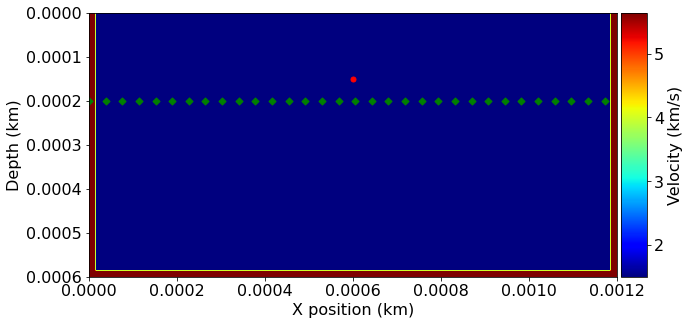

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Operator `Kernel` ran in 192.13 s


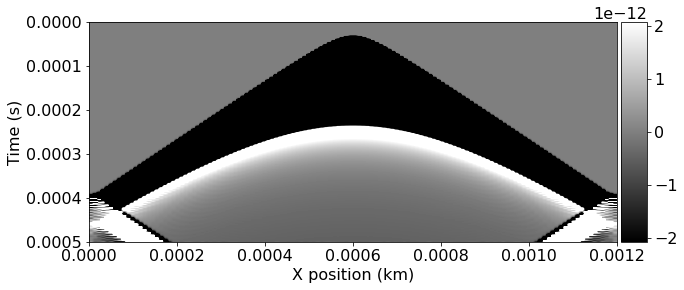

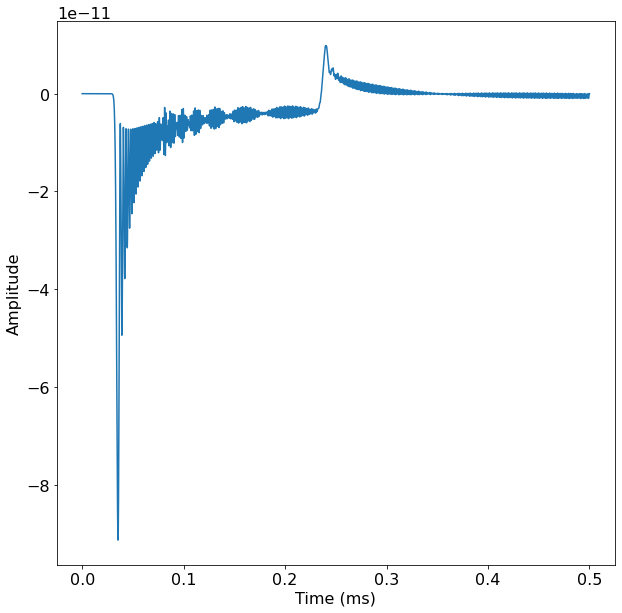

In [7]:
nx = 1601
nz = 801
nb = 10
shape = (nx, nz)
spacing = (.00075, .00075) #60x30 cm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
glass =  int((1.5 / spacing[0]) / 100) # 1.5 cm
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .5  # Simulation lasts tn milliseconds
dt = model.critical_dt # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 1; # number of sources
nr = 128; # number of receivers
depth = .15
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 500 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .2

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values,rec.data[:,64])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()
    

In [ ]:
nx = 801
nz = 401
nb = 10
shape = (nx, nz)
spacing = (.00075, .00075) #60x30 cm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
glass =  int((1.5 / spacing[0]) / 100) # 1.5 cm
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .25  # Simulation lasts tn milliseconds
dt = model.critical_dt # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


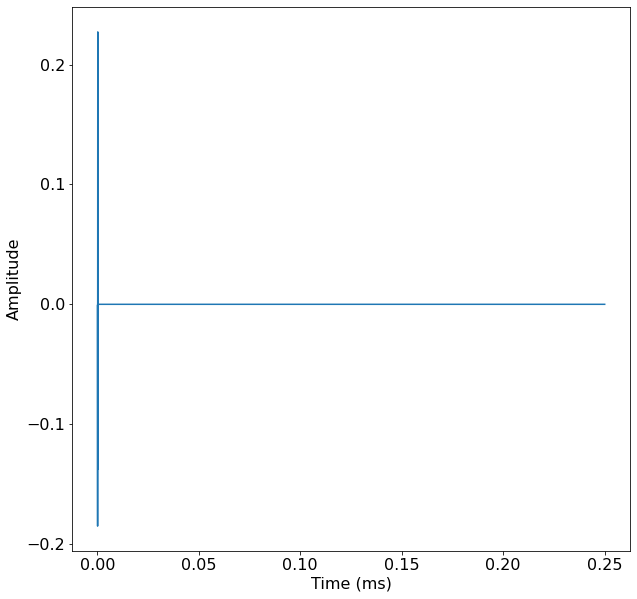

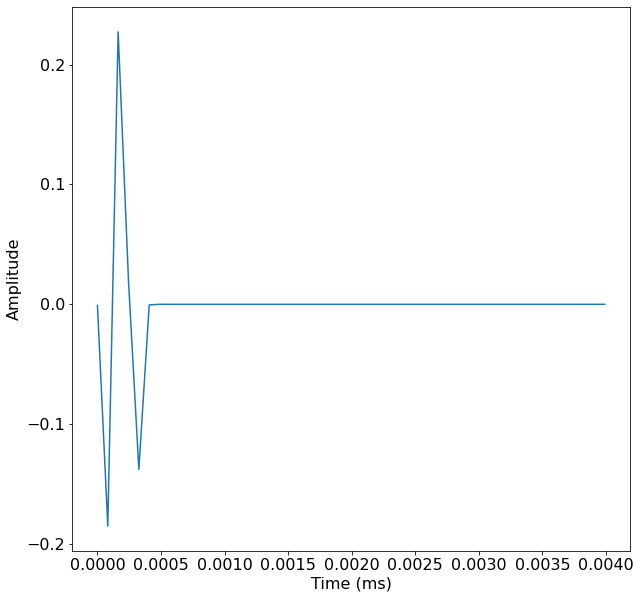

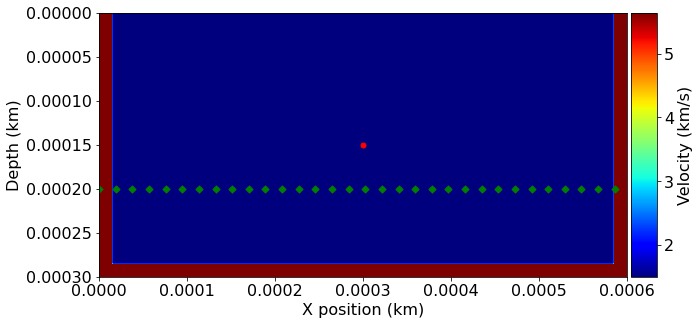

Operator `Kernel` ran in 2.37 s


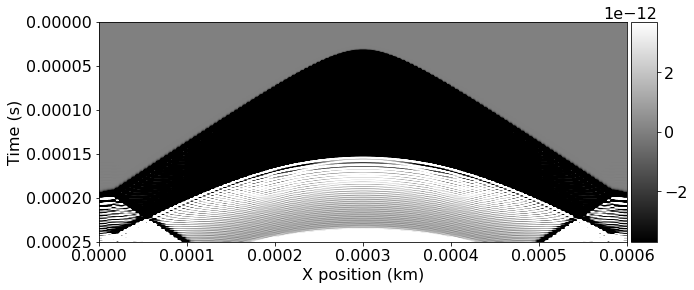

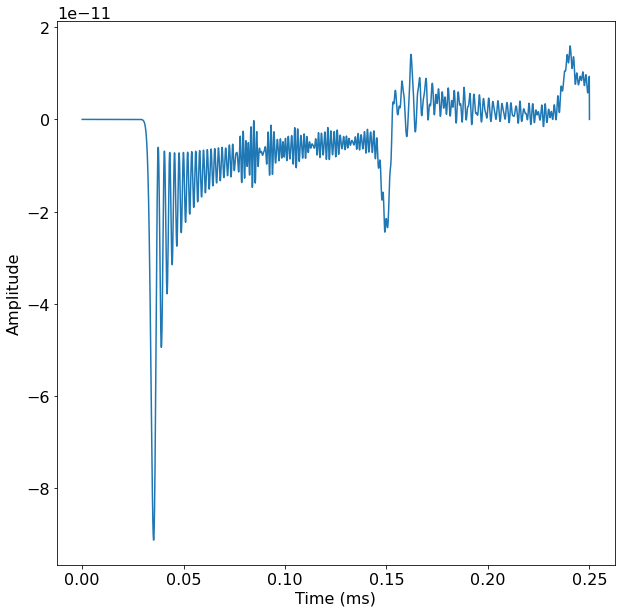

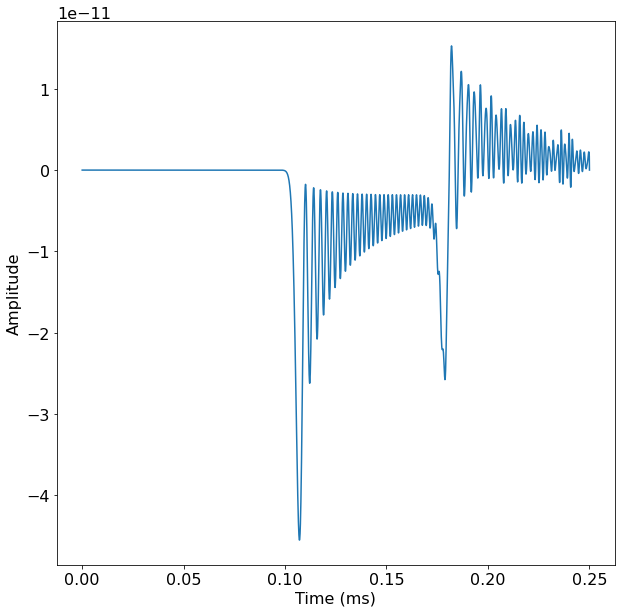

In [9]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 1; # number of sources
nr = 128; # number of receivers
depth = .15
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 500 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .2

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values,rec.data[:,64])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

plt.figure()
plt.plot(src.time_values,rec.data[:,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()
    

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


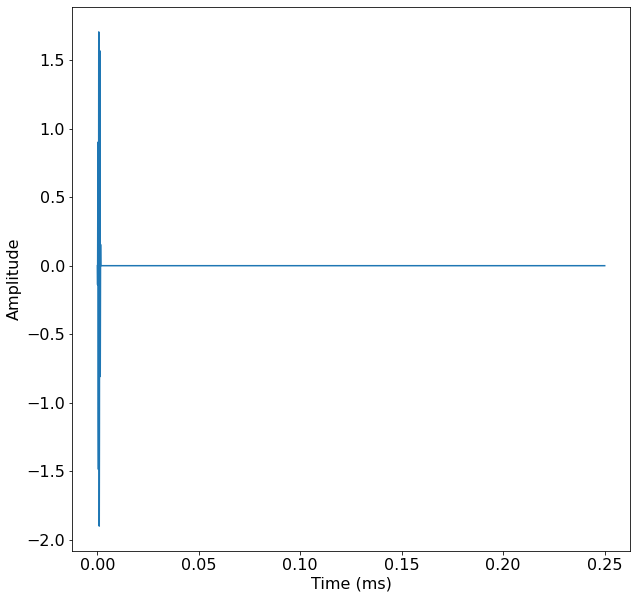

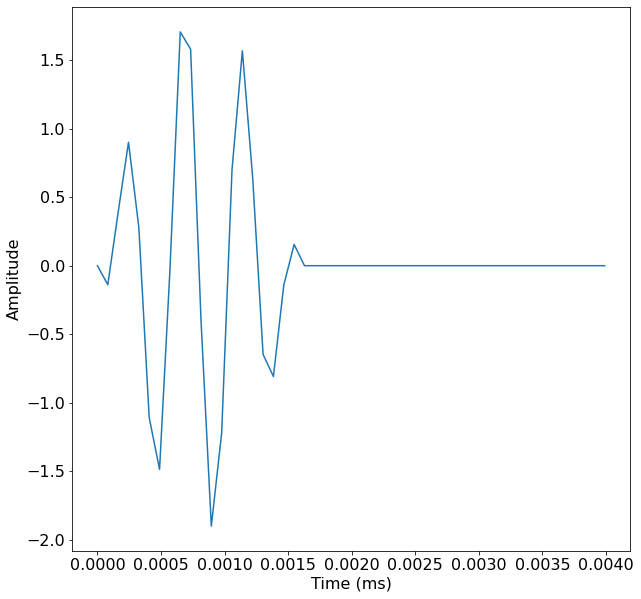

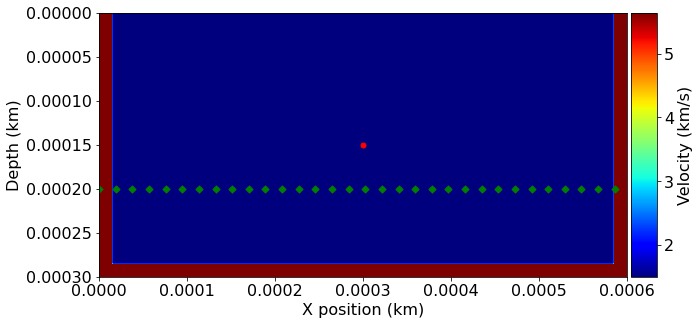

Operator `Kernel` ran in 2.11 s


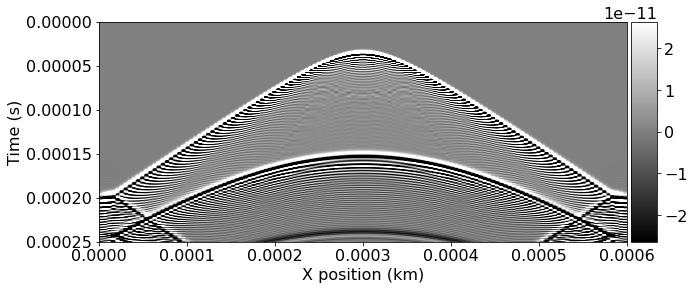

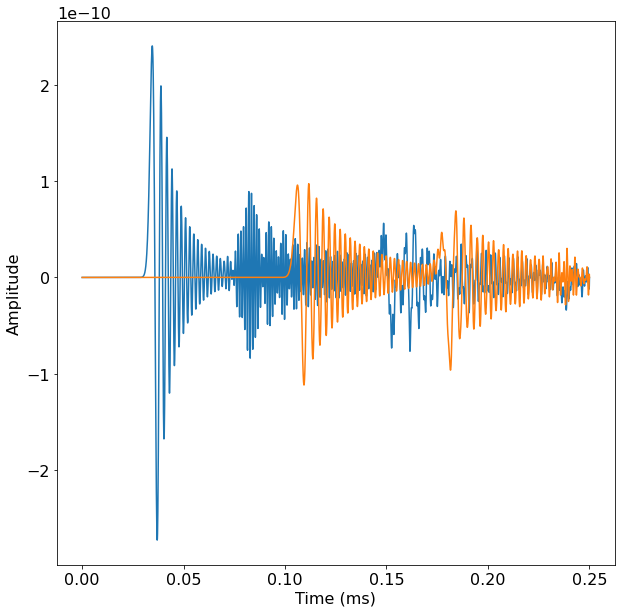

In [13]:
# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .25  # Simulation lasts tn milliseconds
dt = model.critical_dt # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 1; # number of sources
nr = 128; # number of receivers
depth = .15
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 500 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .2

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values,rec.data[:,64])
plt.plot(src.time_values,rec.data[:,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


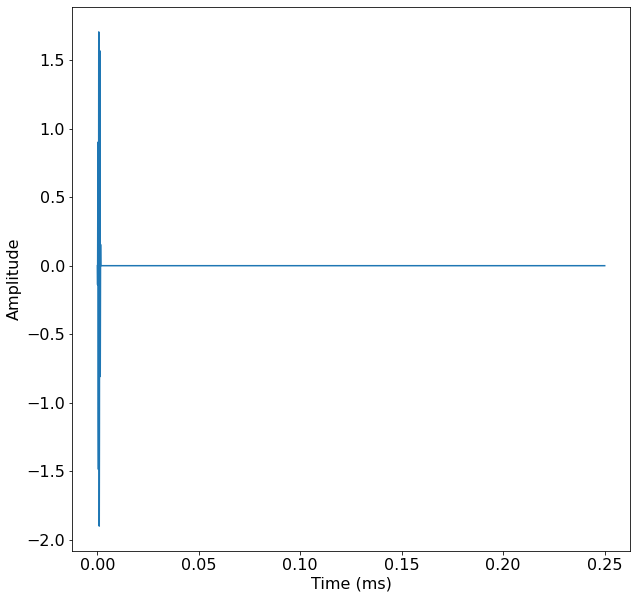

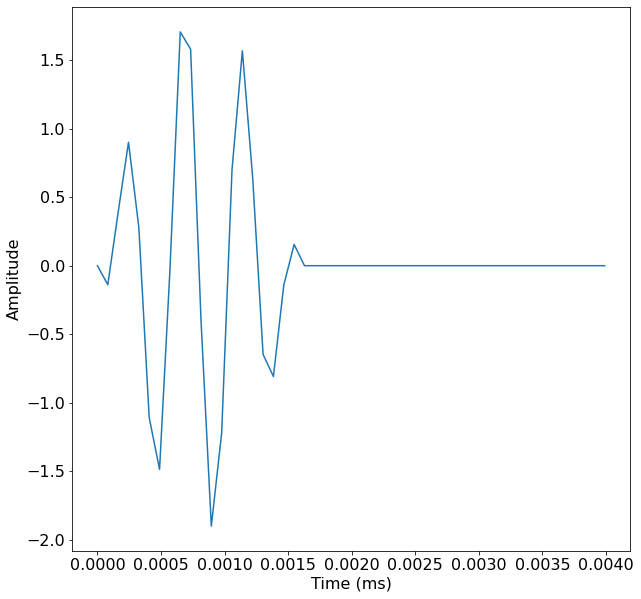

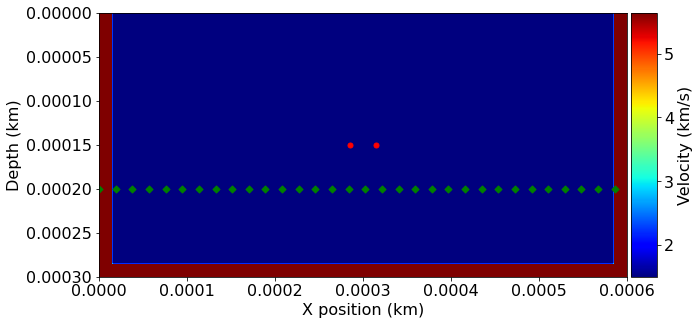

Operator `Kernel` ran in 2.07 s


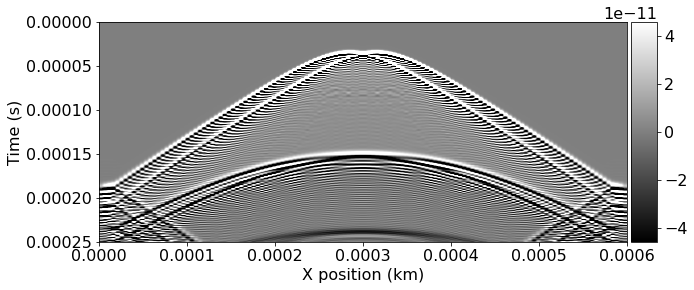

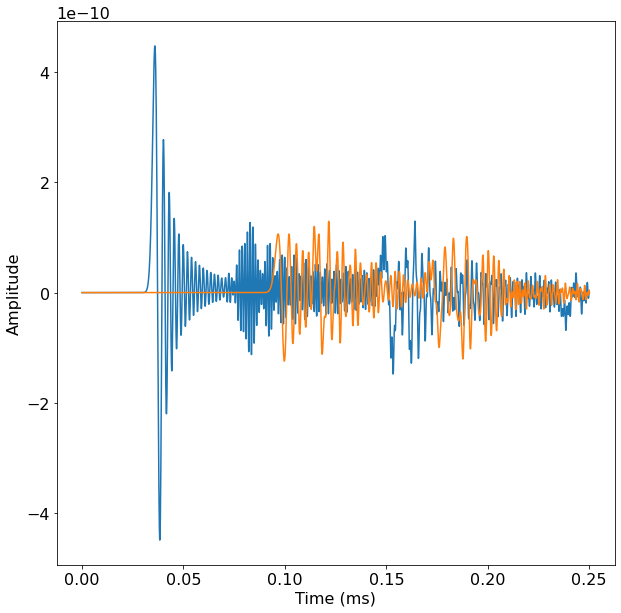

In [16]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 2; # number of sources
nr = 128; # number of receivers
depth = .15
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 100 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .2

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values,rec.data[:,64])
plt.plot(src.time_values,rec.data[:,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


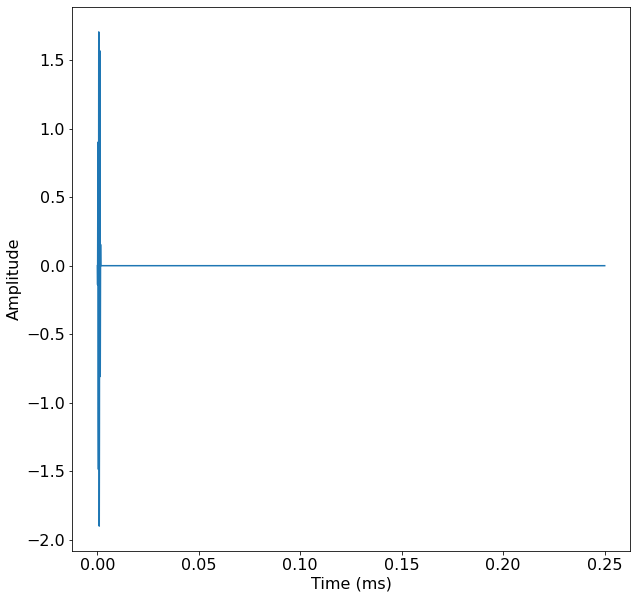

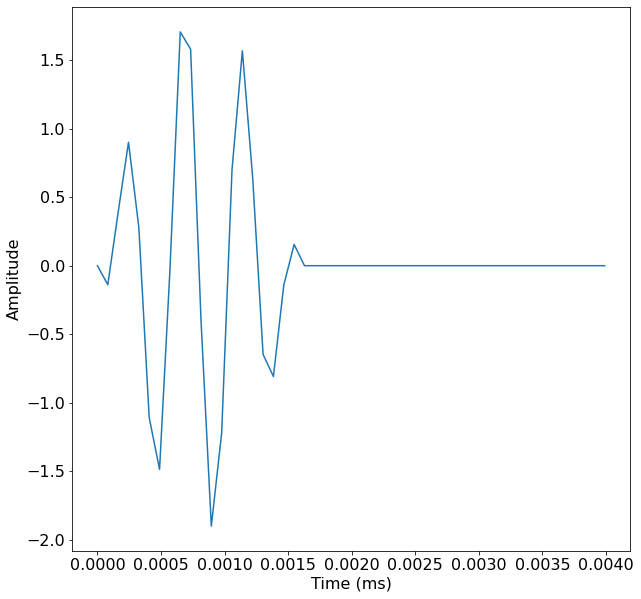

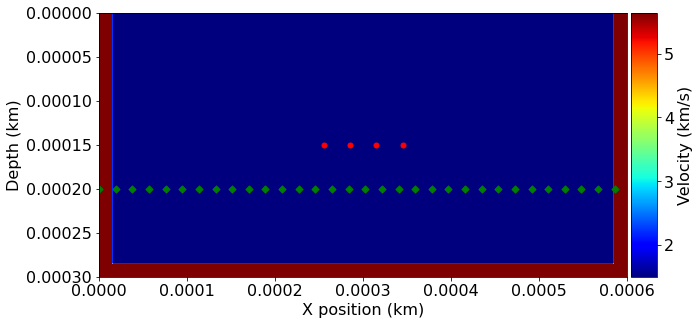

Operator `Kernel` ran in 2.24 s


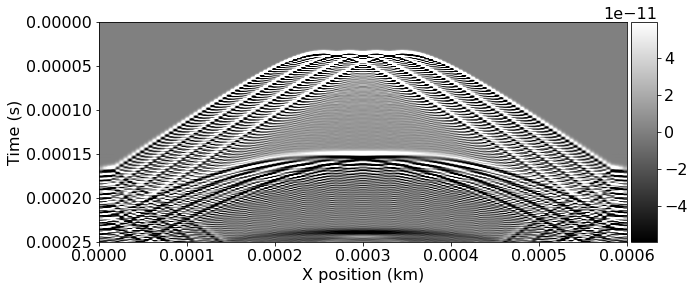

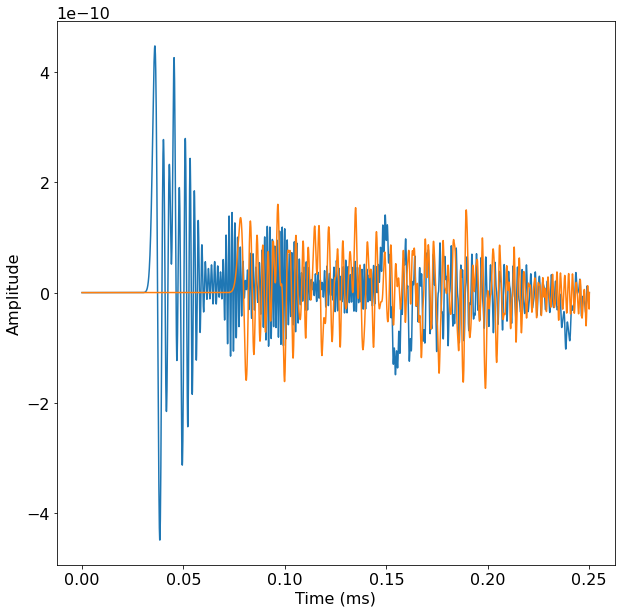

In [18]:
f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 4; # number of sources
nr = 128; # number of receivers
depth = .15
wavelength = v_water / f0
# width = wavelength # 3 cm is the widht of the sources
source_distance = 100 * wavelength
alpha = 90 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
cx = model.domain_size[0] * 0.5
cy = (ns - 1) / 4 * source_distance
pos = srcPositions(cx, cy, alpha, ns, source_distance)

src = SineSource(name='src', grid=model.grid, f0=f0,
                 npoint=ns, time_range=time_range)

src.show()
plt.figure()
plt.plot(src.time_values[0:50], src.data[:50,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

src.coordinates.data[:] = pos[:]
src.coordinates.data[:, -1] = depth

rec = Receiver(name='rec', grid=model.grid,npoint=nr,
               time_range=time_range) 

rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nr)
rec.coordinates.data[:, 1] = .2

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values,rec.data[:,64])
plt.plot(src.time_values,rec.data[:,32])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


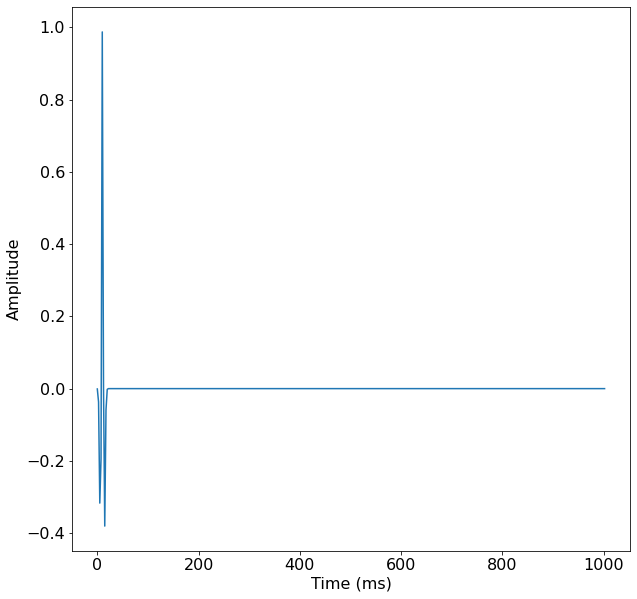

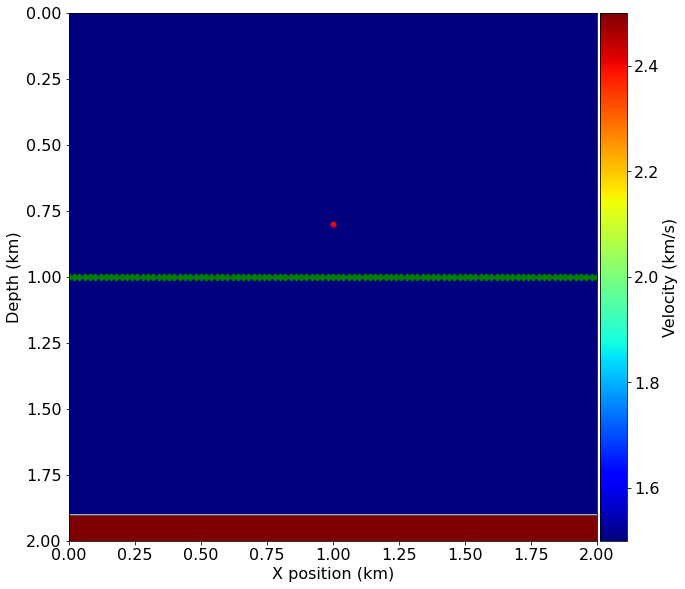

Operator `Kernel` ran in 0.02 s


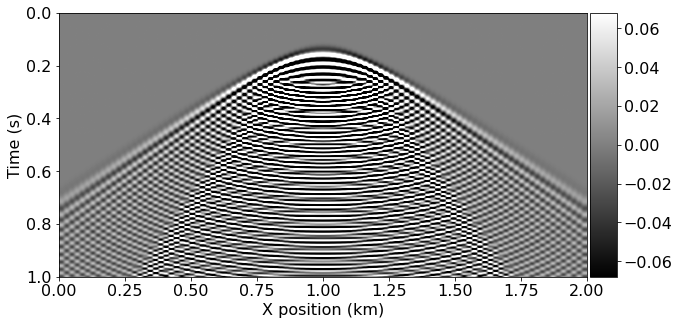

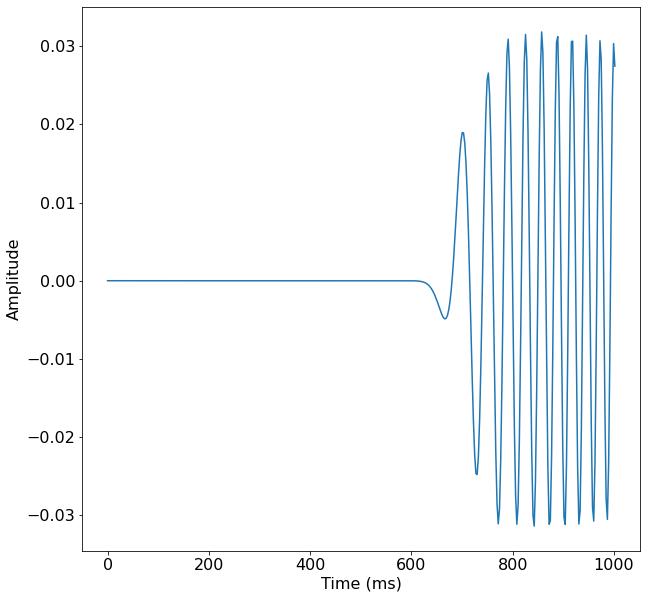

In [21]:
# Define a physical size
shape = (201, 201)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :191] = 1.5
v[:, 191:] = 2.5

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")


#time
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)

#source

f0 = .1  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)
# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 800.  # Depth is 20m
# We can plot the time signature to see the wavelet
src.show()


# Create symbol for 101 receivers
# rec = Receiver(name='rec', grid=model.grid, npoint=3, time_range=time_range)
# Prescribe even spacing for receivers along the x-axis
# rec.coordinates.data[0, 0] = model.domain_size[0]/2-250
# rec.coordinates.data[1, 0] = model.domain_size[0]/2
# rec.coordinates.data[2, 0] = model.domain_size[0]/2+250

rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 1000.  # Depth is 500m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[:, :])

#solve

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op(time=time_range.num-1, dt=model.critical_dt)
plot_shotrecord(rec.data, model, t0, tn)

plt.figure()
plt.plot(src.time_values[0:600],rec.data[0:600,1])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

factor is 60


Operator `Kernel` ran in 4.12 s


Saving snaps file
Dimensions: nz = 421, nx = 821


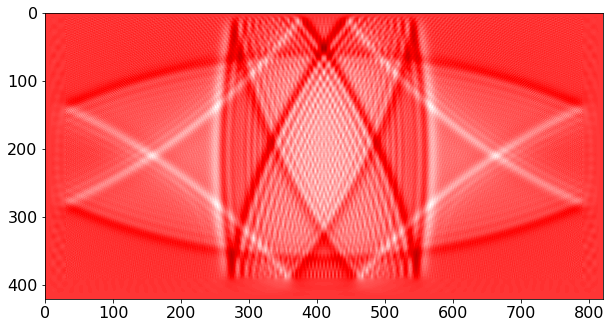

In [16]:
#Used for reshaping
vnx = nx + 2*nb
vnz = nz + 2*nb

# Using params for snapshotting
nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)

op_snapshot = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op_snapshot(time=nt - 2, dt=model.critical_dt)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(nz + 2 * nb, nx + 2 * nb))
filename = "snapshots/snaps.bin"
usave.data.tofile(filename)
fobj = open("snapshots/snaps.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot
v_min = np.min(rec.data)
v_max = np.max(rec.data)
for i in range(0, plot_num):
   # plt.subplot(1, plot_num, i+1);
   imcnt = imcnt + 1
   ind = i * int(nsnaps/plot_num)
   plt.imshow(np.transpose(snaps[ind,:,:]), vmin=v_min, vmax=v_max, cmap="seismic")
   filename = 'snapshots/tmp_%04d.png' % i
   plt.savefig(filename)

plt.show() 